# MUSA 650 Final: Right-of-Way Semantic Segmentation for Urban Areas using GeoNRW

**Authors: Benjamin She, Eli Ericson**

In [1]:
from glob import glob
import os, cv2
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf

from keras.layers import Input, concatenate
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Dropout
from keras.losses import SparseCategoricalCrossentropy
from keras.utils.vis_utils import plot_model
from IPython.display import clear_output

2022-05-03 20:03:22.841985: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# for file in os.listdir(DIR):
#     if file.endswith(".jp2"):
#         img = Image.open(os.dir.join(DIR,file))
#         img.save(os.path.join(DIR,file[0:-4] + ".png"))

In [3]:
## define params

BASEDIR = 'data\\'
CITIES = ['essen']
# CITIES = ['koeln','essen','dortmund','duesseldorf','duisburg']
CLASSES = {
    1:'forest',
    2:'water',
    3:'agricultural',
    4:'urban_fabric',
    5:'grassland',
    6:'railway',
    7:'highway',
    8:'air_ship',
    9:'road',
    10:'building'}

SEED = 650
IMG_SIZE = 256
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

BATCH_SIZE = 16
NUM_CLASSES = 10

AUTOTUNE = tf.data.experimental.AUTOTUNE

## Image preprocessing

In [4]:
filesImg, filesMsk = [], []

for city in CITIES:
    filesImg.extend(glob(os.path.join(BASEDIR,city,"*.jp2")))
    filesMsk.extend(glob(os.path.join(BASEDIR,city,"*seg.tif")))

filesImg.sort()
filesMsk.sort()

print(f"Images: {len(filesImg)} - Masks: {len(filesMsk)}")

LEN_DATA = len(filesImg)

Images: 264 - Masks: 264


In [5]:
def read_image(dir):
    x = cv2.imread(dir, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (512,512))
    x = x.astype(np.uint8)
    return x

def read_mask(dir):
    x = cv2.imread(dir, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (512,512))
    x = np.expand_dims(x, axis=-1)
    x = x.astype(np.uint8)
    return x

def show_img_mask(arrImg, arrMsk, i):
    plt.figure(figsize=(18, 18))
    title = ['Input Image', 'True Mask']
    display_list = [arrImg[i,:,:,:],arrMsk[i,:,:,:]]
    for j in range(len(display_list)):
        plt.subplot(1, len(display_list), j+1)
        plt.title(title[j])
        plt.imshow(display_list[j])
    plt.show()

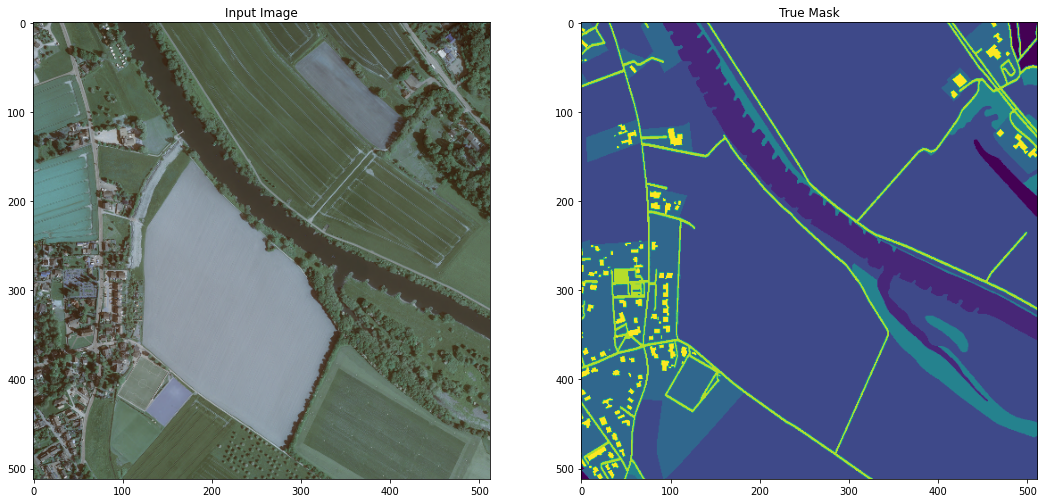

In [5]:
arrImg, arrMsk = [], []

for imgFile in filesImg:
    arrImg.append(read_image(imgFile))
for mskFile in filesMsk:
    arrMsk.append(read_mask(mskFile))

arrImg = np.asarray(arrImg)
arrMsk = np.asarray(arrMsk)

show_img_mask(arrImg, arrMsk, 4)

In [7]:
# split all images and masks into four as orthoimagery scale is too big

arrImgS, arrMskS = [], []

M = arrImg[0].shape[0]//2
N = arrImg[0].shape[1]//2

for im in arrImg:
    arrImgS.extend([im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)])

for mk in arrMsk:
    arrMskS.extend([mk[x:x+M,y:y+N] for x in range(0,mk.shape[0],M) for y in range(0,mk.shape[1],N)])

arrImgS = np.asarray(arrImgS)
arrMskS = np.asarray(arrMskS)

In [8]:
def getMasksClasses(masklist, numClasses):
    '''returns a dict with the indices of masks sorted by the number of classes
    present in them'''
    # get the classes present on each mask
    classesPresent = np.array([np.unique(mask) for mask in masklist], dtype=object)
    
    # create empty dictionary
    totClassDict = {}

    # classify images by number of classes present in each
    for i in range(1, numClasses+1):
        totalClasses = np.where(np.asarray([array.shape[0] for array in classesPresent]) == i)
        totClassDict[i] = totalClasses[0]
    
    return totClassDict

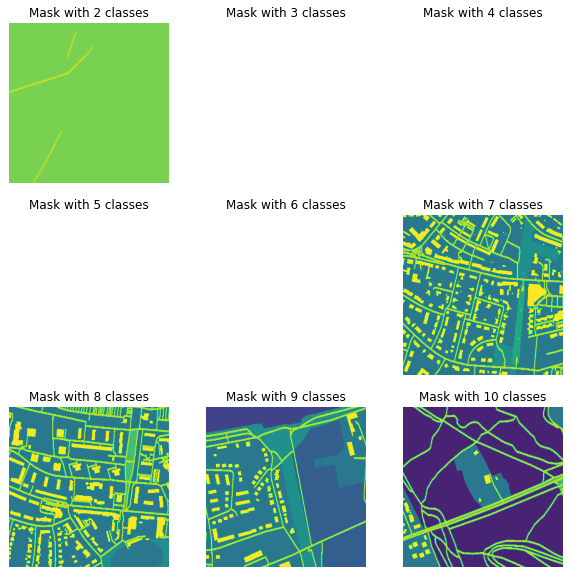

In [9]:
# get classes by masks
mskByClass = getMasksClasses(arrMskS, NUM_CLASSES)

# plot examples of images with different numbers of classes
fig, axes = plt.subplots(figsize=(10, 10), nrows=3, ncols=3, sharey=True)
[axi.set_axis_off() for axi in axes.ravel()]

for i in range(1, NUM_CLASSES):
  ax = axes.flatten()[i-1]
  ax.set_title(f'Mask with {i+1} classes')
  classMsk = arrMskS[mskByClass[i+1]]
  if np.any(classMsk):
    ax.imshow(arrMskS[mskByClass[i+1][np.random.randint(classMsk.shape[0])]], vmin=0, vmax=NUM_CLASSES)

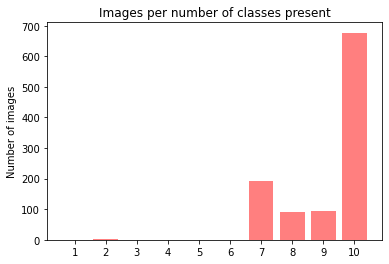

In [38]:
# get total of images per number of classes present
totByClass = [mskByClass[i].shape[0] for i in range(1,NUM_CLASSES+1)]

# plot bar
plt.bar(np.arange(1,NUM_CLASSES+1), totByClass, align='center', color='red', alpha=0.5)
plt.xticks(np.arange(1,NUM_CLASSES+1))
plt.ylabel('Number of images')
plt.title("Images per number of classes present")
plt.show()

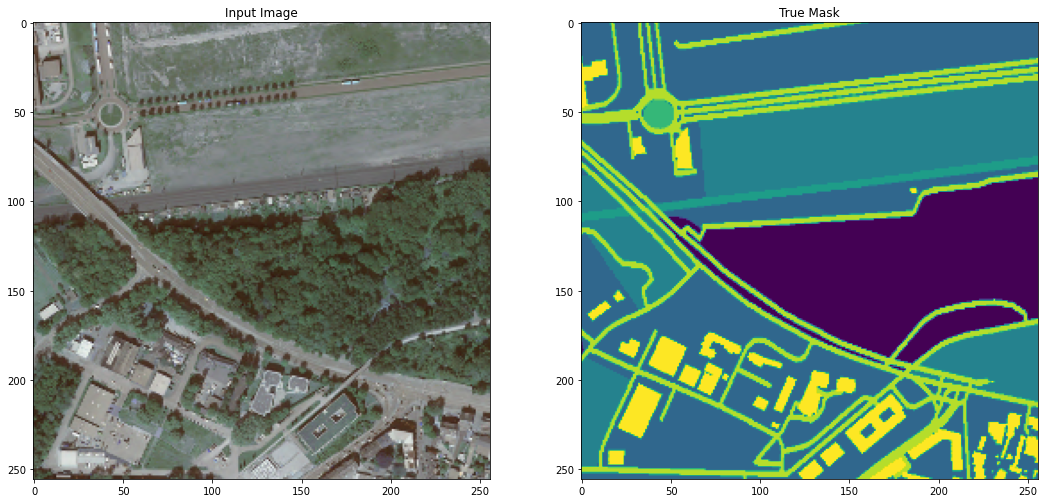

In [39]:
# get index of masks that contain highways or roadways and filter dataset to only those

ROWidxs = []
for i in range(len(arrMskS)):
    if True in np.in1d(arrMskS[i].flatten(),[6,7,9]):
        ROWidxs.append(i)

arrImgS = np.take(arrImgS,ROWidxs,axis=0)
arrMskS = np.take(arrMskS,ROWidxs,axis=0)

[len(arrImgS), len(ROWidxs)]

show_img_mask(arrImgS, arrMskS, 4)

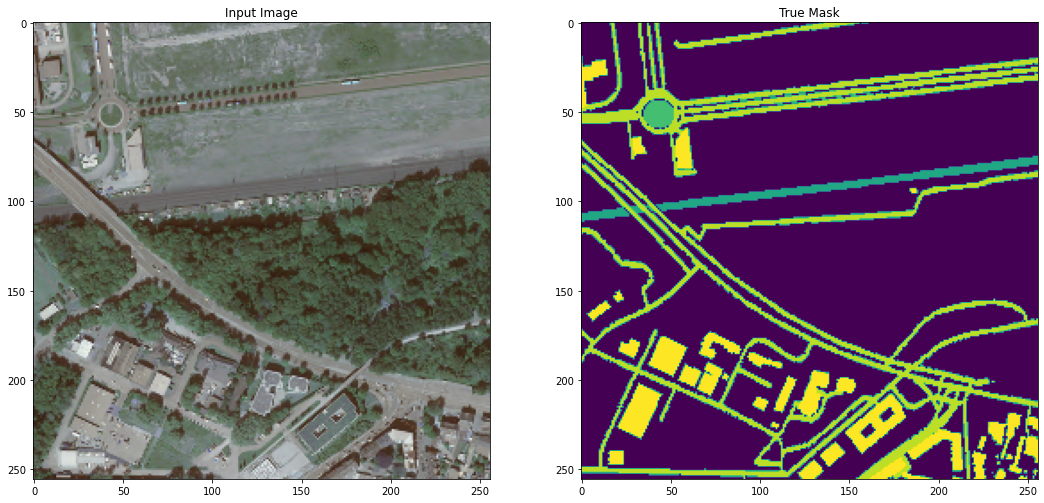

In [12]:
# reduce semantic classes to highways, roadways, railways, buildings, and all other

classSel = {1:6, 2:7, 3:9, 4:10}

arrMskFilt = []

for mk in arrMskS:
    q = np.isin(mk, np.fromiter(classSel.values(), dtype=int)) == False
    mk[q] = 0
    np.vectorize(classSel.get)(mk)
    arrMskFilt.append(mk)

arrMskS = np.asarray(arrMskFilt)

show_img_mask(arrImgS, arrMskS, 4)

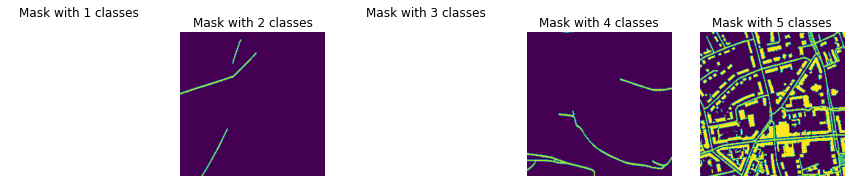

In [13]:
NUM_CLASSES_RED = len(np.unique(arrMskS))

# get classes by masks
mskByClass = getMasksClasses(arrMskS, NUM_CLASSES_RED)

# plot examples of images with different numbers of classes
fig, axes = plt.subplots(figsize=(15,3), nrows=1, ncols=5, sharey=True)
[axi.set_axis_off() for axi in axes.ravel()]

for i in mskByClass.keys():
  ax = axes.flatten()[i-1]
  ax.set_title(f'Mask with {i} classes')
  classMsk = arrMskS[mskByClass[i]]
  if np.any(classMsk):
    ax.imshow(arrMskS[mskByClass[i][np.random.randint(classMsk.shape[0])]], vmin=0, vmax=NUM_CLASSES)



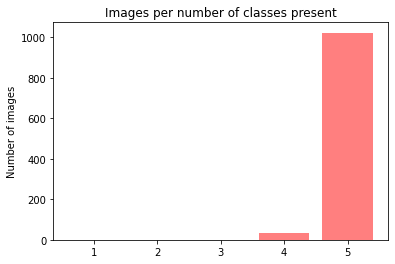

In [14]:
# get total of images per number of classes present
totByClass = [mskByClass[i].shape[0] for i in range(1,NUM_CLASSES_RED+1)]

# plot bar
plt.bar(np.arange(1,NUM_CLASSES_RED+1), totByClass, align='center', color='red', alpha=0.5)
plt.xticks(np.arange(1,NUM_CLASSES_RED+1))
plt.ylabel('Number of images')
plt.title("Images per number of classes present")
plt.show()

## CNN modeling (U-Net)

In [15]:
# geonrw = tf.data.Dataset.from_tensor_slices((arrImgS, arrMskS))
# geonrw = geonrw.shuffle(buffer_size=LEN_DATA)
# geonrw = geonrw.batch(BATCH_SIZE)
# geonrw = geonrw.prefetch(buffer_size=AUTOTUNE)

In [16]:
# dataset = {"train":geonrw.take(int(LEN_DATA / BATCH_SIZE * 0.7)),
#             "test":geonrw.skip(int(LEN_DATA / BATCH_SIZE * 0.7))}

In [17]:
# Split to train and test sets
X_tr, X_te, y_tr, y_te = train_test_split(
    arrImgS,
    arrMskS,
    test_size = 0.2,
    shuffle = True,
    random_state = SEED)

In [18]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = MaxPooling2D(2)(f)
   p = Dropout(0.2)(p)
   return f, p

def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def upsample_block(x, conv_features, n_filters):
   x = Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = concatenate([x, conv_features])
   x = Dropout(0)(x)
   x = double_conv_block(x, n_filters)
   return x

In [19]:
def build_unet():
    # inputs
    inputs = Input(shape=(INPUT_SHAPE))
    # encoder: contracting dir - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # decoder: expanding dir - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # outputs
    outputs = Conv2D(5, 1, padding="same", activation = "softmax")(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model

In [20]:
model = build_unet()

model.summary()

Error: Canceled future for execute_request message before replies were done

In [ ]:
def display_sample(display_list):

    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    """Return a filter mask with the top 1 predictions
    only.

    Parameters
    ----------
    pred_mask : tf.Tensor
        A [IMG_SIZE, IMG_SIZE, N_CLASS] tensor. For each pixel we have
        N_CLASS values (vector) which represents the probability of the pixel
        being these classes. Example: A pixel with the vector [0.0, 0.0, 1.0]
        has been predicted class 2 with a probability of 100%.

    Returns
    -------
    tf.Tensor
        A [IMG_SIZE, IMG_SIZE, 1] mask with top 1 predictions
        for each pixels.
    """
    # pred_mask -> [IMG_SIZE, SIZE, N_CLASS]
    # 1 prediction for each class but we want the highest score only
    # so we use argmax
    pred_mask = tf.argmax(pred_mask, axis=-1)
    # pred_mask becomes [IMG_SIZE, IMG_SIZE]
    # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

def show_predictions(dataset=None, num=1):
    """Show a sample prediction.

    Parameters
    ----------
    dataset : [type], optional
        [Input dataset, by default None
    num : int, optional
        Number of sample to show, by default 1
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], mask, create_mask(pred_mask)])
    else:
        # The model is expecting a tensor of the size
        # [BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3]
        # but sample_image[0] is [IMG_SIZE, IMG_SIZE, 3]
        # and we want only 1 inference to be faster
        # so we add an additional dimension [1, IMG_SIZE, IMG_SIZE, 3]
        one_img_batch = sample_image[0][tf.newaxis, ...]
        # one_img_batch -> [1, IMG_SIZE, IMG_SIZE, 3]
        inference = model.predict(one_img_batch)
        # inference -> [1, IMG_SIZE, IMG_SIZE, N_CLASS]
        pred_mask = create_mask(inference)
        # pred_mask -> [1, IMG_SIZE, IMG_SIZE, 1]
        display_sample([sample_image[0], sample_mask[0],
                        pred_mask[0]])
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
NUM_EPOCHS = 20
TRAIN_SIZE = len(dataset['train'])
TEST_SIZE = len(dataset['test'])
STEPS_PER_EPOCH = TRAIN_SIZE // BATCH_SIZE
VALIDATION_STEPS = TEST_SIZE // BATCH_SIZE

callbacks = [
    # to show samples after each epoch
    DisplayCallback(),
    # if no accuracy improvements we can stop the training directly
    tf.keras.callbacks.EarlyStopping(patience=8, verbose=1),
    # to save checkpoints
    tf.keras.callbacks.ModelCheckpoint('best_model_unet.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

model_history = model.fit(dataset['train'],
                          epochs=NUM_EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=dataset['test'],
                          verbose=1,
                          callbacks=callbacks)

In [ ]:
from numba import cuda
cuda.get_current_device().reset()